In [1]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
!pip install kmodes


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv",sep="\t")


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
pd.set_option('display.max_columns', None)
df.describe().round()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.0,2240.0,2216.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0
mean,5592.0,1969.0,52247.0,0.0,1.0,49.0,304.0,26.0,167.0,38.0,27.0,44.0,2.0,4.0,3.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
std,3247.0,12.0,25173.0,1.0,1.0,29.0,337.0,40.0,226.0,55.0,41.0,52.0,2.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1893.0,1730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
25%,2828.0,1959.0,35303.0,0.0,0.0,24.0,24.0,1.0,16.0,3.0,1.0,9.0,1.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
50%,5458.0,1970.0,51382.0,0.0,0.0,49.0,174.0,8.0,67.0,12.0,8.0,24.0,2.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
75%,8428.0,1977.0,68522.0,1.0,1.0,74.0,504.0,33.0,232.0,50.0,33.0,56.0,3.0,6.0,4.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
max,11191.0,1996.0,666666.0,2.0,2.0,99.0,1493.0,199.0,1725.0,259.0,263.0,362.0,15.0,27.0,28.0,13.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,11.0,1.0


In [7]:
num_unique_consumerID = df['ID'].nunique()
num_unique_consumerID

2240

In [8]:
df = df.rename(columns={'Response': 'AcceptedCmp6'})


In [9]:
 # Create a dictionary to map the campaign numbers to the column names
campaign_dict = {'AcceptedCmp1': 1, 'AcceptedCmp2': 2, 'AcceptedCmp3': 3,
                 'AcceptedCmp4': 4, 'AcceptedCmp5': 5, 'AcceptedCmp6': 6}

# Loop through the rows and find the campaign where the customer accepted the offer
for i in range(len(df)):
    for col, campaign in campaign_dict.items():
        if df.loc[i, col] == 1:
            df.loc[i, 'AcceptedCmp'] = campaign
            break
    else:
        df.loc[i, 'AcceptedCmp'] = 0

# Delete the original campaign columns
df.drop(columns=campaign_dict.keys(), inplace=True)


In [10]:
df['AcceptedCmp'] = df['AcceptedCmp'].astype('object')
df['Teenhome'] = df['Teenhome'].astype('object')
df['Kidhome'] = df['Kidhome'].astype('object')
df['Complain'] = df['Complain'].astype('object')

creating a new column age and enrollment_time and deleting year_birth and Dt_customer columns

In [11]:


# calculate age based on Year_Birth
current_year = dt.datetime.now().year
df['Age'] = current_year - df['Year_Birth']

# convert 'Dt_Customer' to datetime format and calculate enrollment time
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Enrollment_time'] = ((dt.datetime.now() - df['Dt_Customer']).dt.days / 12).round(1)

# drop the original columns
df.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)



In [12]:
# deleting the z_costcontact and Z_revenue columns as they have constant values. 
df = df.drop(columns=['Z_CostContact', 'Z_Revenue', 'ID'])

In [13]:
df.describe().round()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Enrollment_time
count,2216.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0
mean,52247.0,49.0,304.0,26.0,167.0,38.0,27.0,44.0,2.0,4.0,3.0,6.0,5.0,54.0,297.0
std,25173.0,29.0,337.0,40.0,226.0,55.0,41.0,52.0,2.0,3.0,3.0,3.0,2.0,12.0,17.0
min,1730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,268.0
25%,35303.0,24.0,24.0,1.0,16.0,3.0,1.0,9.0,1.0,2.0,0.0,3.0,3.0,46.0,283.0
50%,51382.0,49.0,174.0,8.0,67.0,12.0,8.0,24.0,2.0,4.0,2.0,5.0,6.0,53.0,297.0
75%,68522.0,74.0,504.0,33.0,232.0,50.0,33.0,56.0,3.0,6.0,4.0,8.0,7.0,64.0,312.0
max,666666.0,99.0,1493.0,199.0,1725.0,259.0,263.0,362.0,15.0,27.0,28.0,13.0,20.0,130.0,326.0


In [14]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,AcceptedCmp,Age,Enrollment_time
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,6.0,66,322.8
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0.0,69,276.9
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0.0,58,293.5
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0.0,39,279.1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0.0,42,280.9


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Marital_Status       2240 non-null   object 
 2   Income               2216 non-null   float64
 3   Kidhome              2240 non-null   object 
 4   Teenhome             2240 non-null   object 
 5   Recency              2240 non-null   int64  
 6   MntWines             2240 non-null   int64  
 7   MntFruits            2240 non-null   int64  
 8   MntMeatProducts      2240 non-null   int64  
 9   MntFishProducts      2240 non-null   int64  
 10  MntSweetProducts     2240 non-null   int64  
 11  MntGoldProds         2240 non-null   int64  
 12  NumDealsPurchases    2240 non-null   int64  
 13  NumWebPurchases      2240 non-null   int64  
 14  NumCatalogPurchases  2240 non-null   int64  
 15  NumStorePurchases    2240 non-null   i

In [16]:
df = df.dropna(subset=['Income']).reset_index(drop=True)

In [17]:
# select columns with data type 'object'
object_cols = df.select_dtypes(include=['object']).columns

# get the index of the object columns
object_cols_index = object_cols.to_list()

object_cols_index = [df.columns.get_loc(col) for col in object_cols]


print(object_cols_index)  # prints [1, 2]


[0, 1, 3, 4, 17, 18]


In [18]:
# select only the non-object columns
non_obj_cols = df.select_dtypes(exclude=['object']).columns

# apply standardization to the non-object columns
scaler = StandardScaler()
df[non_obj_cols] = scaler.fit_transform(df[non_obj_cols])


df.describe().round()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Enrollment_time
count,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0
mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.0,-2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
75%,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
max,24.0,2.0,4.0,4.0,7.0,4.0,6.0,5.0,7.0,8.0,9.0,2.0,6.0,6.0,2.0


applying the elbow method 

In [19]:
cost = []
for num_clusters in list(range(1,8)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df, categorical=object_cols_index)
    cost.append(kproto.cost_)

# plt.plot(range(1, 8), cost)
# plt.xlabel('Number of clusters')
# plt.ylabel('Cost')
# plt.title('Elbow Method for Optimal k')
# plt.show()


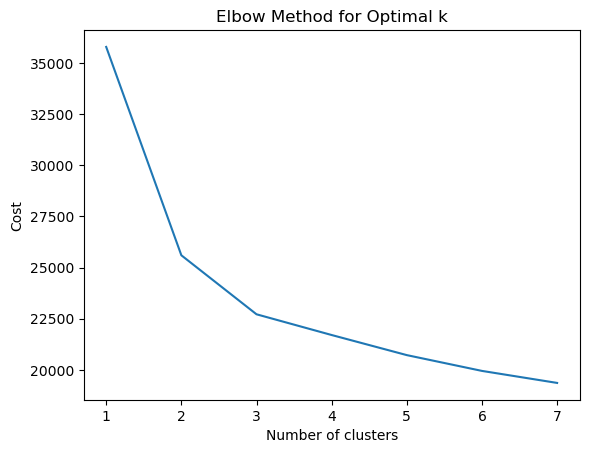

In [20]:
plt.plot(range(1, 8), cost)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

K=3 seems like a good choice. so lets re-train with k=3 this time with more initializations.

In [21]:
    kproto = KPrototypes(n_clusters=3, init='Cao', n_init=100)
    kproto.fit_predict(df, categorical=object_cols_index)


array([2, 0, 2, ..., 1, 2, 0], dtype=uint16)

In [22]:
df['cluster']=kproto.labels_